# Waste Classification with EfficientNetB0

This notebook builds an end-to-end image classification pipeline for multi-class waste sorting using EfficientNetB0. It covers data acquisition from Google Drive, preprocessing, training with regularization and optimization callbacks, and model evaluation/testing with multiple metrics.


## Workflow Overview

1. **Data acquisition** – Mount Google Drive (or download) and set dataset paths.
2. **Data preprocessing** – Build TensorFlow datasets with augmentation, batching, caching, and normalization.
3. **Model creation** – Fine-tune EfficientNetB0 with dropout, L2 regularization, Adam optimizer, and learning-rate scheduling. Save the best model as `.h5`.
4. **Model evaluation** – Report loss, accuracy, precision, recall, F1, confusion matrix, and classification report on validation/test sets.
5. **Model testing** – Run single-image inference utilities for manual inspection.


In [1]:
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score



In [2]:
# Global config
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

plt.style.use("seaborn-v0_8")
sns.set_context("talk", font_scale=0.9)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.2
L2_REG = 1e-4
AUTOTUNE = tf.data.AUTOTUNE



## Data Acquisition

The dataset lives on Google Drive with class-specific folders:

- `Cardboard`, `Food Organics`, `Glass`, `Metal`, `Miscellaneous Trash`, `Paper`, `Plastic`, `Textile Trash`, `Vegetation`

Each folder should contain JPEG/PNG images. Update the `DRIVE_DATASET_PATH` below to point to the root directory that holds these class folders (or to a parent directory containing `train`, `val`, and `test` splits).


In [3]:
# Mount Google Drive when running in Google Colab (safe to skip elsewhere)
from google.colab import drive
drive.mount('/content/drive')

DATASET_ROOT = Path(os.getenv("WASTE_DATASET_PATH", "/content/drive/MyDrive/realwaste-main/RealWaste"))
MODEL_DIR = Path(os.getenv("WASTE_MODEL_DIR", "/content/drive/MyDrive/waste-classification-v2"))
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / "efficientnetb0_waste_classifier.h5"
DATASET_ROOT


Mounted at /content/drive


PosixPath('/content/drive/MyDrive/realwaste-main/RealWaste')

In [4]:
if not DATASET_ROOT.exists():
    raise FileNotFoundError(
        f"Dataset path {DATASET_ROOT} was not found. Set WASTE_DATASET_PATH env variable or update DEFAULT_DATASET_PATH."
    )

class_names = sorted([entry.name for entry in DATASET_ROOT.iterdir() if entry.is_dir()])
print(f"Found {len(class_names)} classes:")
for name in class_names:
    num_files = len(list((DATASET_ROOT / name).glob("*.jpg"))) + len(list((DATASET_ROOT / name).glob("*.png")))
    print(f" - {name}: ~{num_files} images (jpg/png)")


Found 9 classes:
 - Cardboard: ~390 images (jpg/png)
 - Food Organics: ~380 images (jpg/png)
 - Glass: ~390 images (jpg/png)
 - Metal: ~389 images (jpg/png)
 - Miscellaneous Trash: ~410 images (jpg/png)
 - Paper: ~398 images (jpg/png)
 - Plastic: ~400 images (jpg/png)
 - Textile Trash: ~318 images (jpg/png)
 - Vegetation: ~390 images (jpg/png)


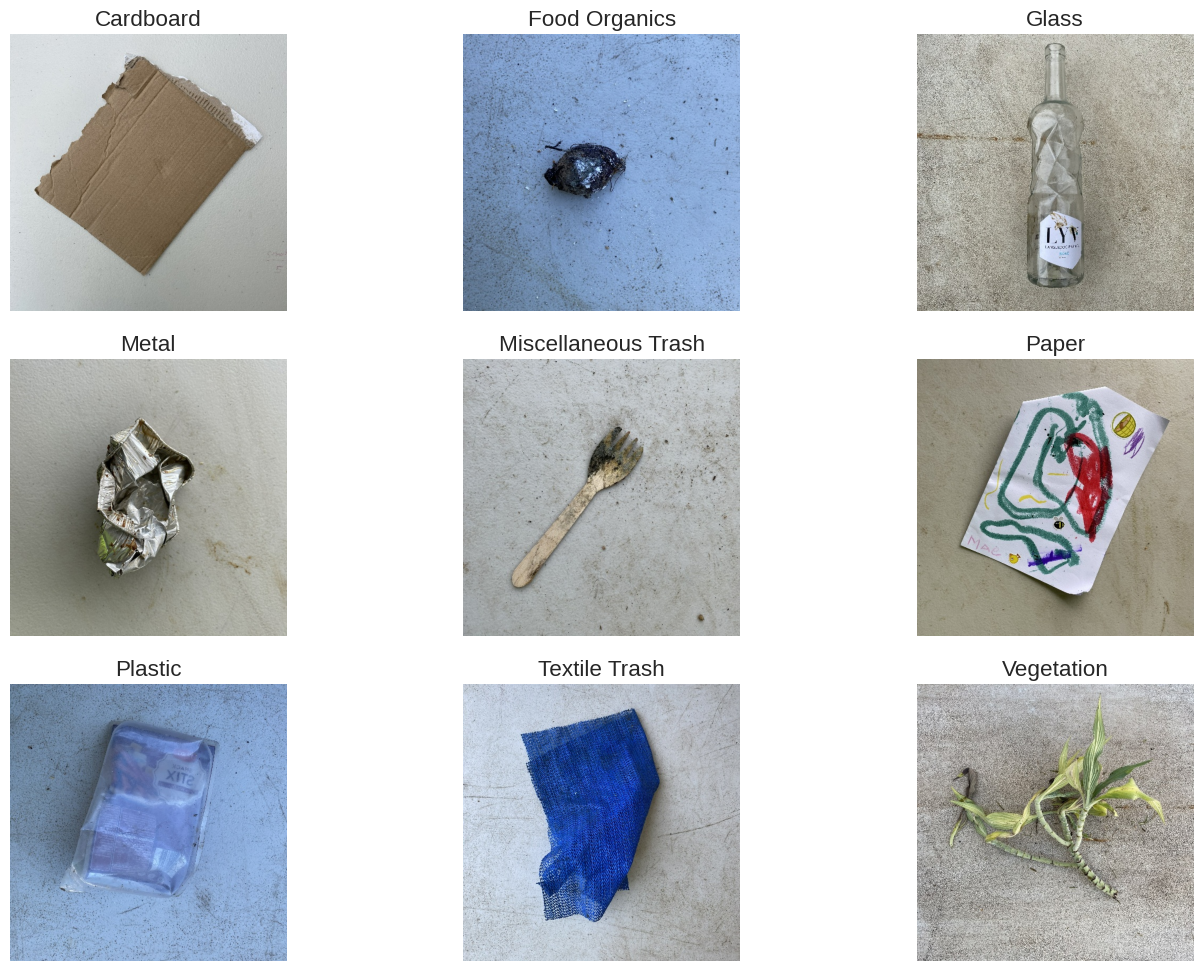

In [11]:
#Visualize few images from the loaded dataset

# Display a few images from each class
num_images_to_display = 1 # Display one image per class

plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    class_path = DATASET_ROOT / class_name
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:
        for _ in range(num_images_to_display):
            random_image = random.choice(image_files)
            image_path = class_path / random_image
            img = Image.open(image_path)

            plt.subplot(3, 3, i + 1) # Assuming there are 9 classes for 3x3 grid
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    else:
        print(f"No image files found for class: {class_name}")

plt.tight_layout()
plt.show()

## Data Processing

We create TensorFlow datasets directly from the directory tree, applying:

- stratified split (70% train, 15% validation, 15% test) using a deterministic seed
- on-the-fly augmentation: random flip, rotation, color jitter
- batching, caching, shuffling, and prefetching to keep GPUs busy
- EfficientNetB0-specific normalization (built-in preprocessing layer)



In [5]:
VAL_TEST_SPLIT = 0.3  # 70% train, 30% temp (which we split into val/test)

base_kwargs = dict(
    directory=DATASET_ROOT,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    interpolation="bilinear",
    shuffle=True,
    seed=SEED,
    color_mode="rgb", # Changed back to RGB to ensure consistent input for conversion
)

train_ds = image_dataset_from_directory(
    **base_kwargs,
    validation_split=VAL_TEST_SPLIT,
    subset="training",
)
val_test_ds = image_dataset_from_directory(
    **base_kwargs,
    validation_split=VAL_TEST_SPLIT,
    subset="validation",
)

val_test_cardinality = tf.data.experimental.cardinality(val_test_ds)
val_batches = val_test_cardinality // 2

def split_validation_and_test(dataset, val_batches):
    val_dataset = dataset.take(val_batches)
    test_dataset = dataset.skip(val_batches)
    return val_dataset, test_dataset

val_ds, test_ds = split_validation_and_test(val_test_ds, val_batches)

print(f"Train batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds)}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds)}")

Found 3465 files belonging to 9 classes.
Using 2426 files for training.
Found 3465 files belonging to 9 classes.
Using 1039 files for validation.
Train batches: 76
Validation batches: 16
Test batches: 17


In [6]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

preprocess = keras.applications.efficientnet.preprocess_input

def prepare(ds, training=False):
    ds = ds.cache()
    if training:
        ds = ds.shuffle(1000, seed=SEED)
    ds = ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds_ready = prepare(train_ds, training=True)
val_ds_ready = prepare(val_ds)
test_ds_ready = prepare(test_ds)



## Model Creation – EfficientNetB0 Backbone

We fine-tune EfficientNetB0 pretrained on ImageNet. The network includes:

- data augmentation and EfficientNet preprocessing
- global average pooling + dropout (`0.2`)
- dense classifier with L2 regularization to reduce overfitting
- Adam optimizer (`lr=1e-3`), categorical cross-entropy loss
- callbacks: early stopping, model checkpoint, reduce-on-plateau


In [7]:
def build_model(num_classes: int) -> keras.Model:
    inputs = layers.Input(shape=IMG_SIZE + (3,), name="input_image")
    x = data_augmentation(inputs)
    x = preprocess(x)

    base_model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # freeze for warm-up

    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.Dropout(DROPOUT_RATE, name="dropout")(x) # Fixed: Apply dropout layer to tensor x
    outputs = layers.Dense(
        num_classes,
        activation="softmax",
        kernel_regularizer=regularizers.l2(L2_REG),
        name="classifier",
    )(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="EfficientNetB0_waste")

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.TopKCategoricalAccuracy(k=3, name="top3_acc"),
        ],
    )
    return model

model = build_model(len(class_names))
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0_waste"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,061,100 (15.49 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="max",
    restore_best_weights=True,
    verbose=1,
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)
checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_PATH,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

history = model.fit(
    train_ds_ready,
    epochs=EPOCHS,
    validation_data=val_ds_ready,
    callbacks=[early_stop, reduce_lr, checkpoint],
)



Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3502 - loss: 1.7917 - precision: 0.6395 - recall: 0.0667 - top3_acc: 0.6660
Epoch 1: val_accuracy improved from -inf to 0.73047, saving model to /content/drive/MyDrive/waste-classification-v2/efficientnetb0_waste_classifier.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.3523 - loss: 1.7871 - precision: 0.6426 - recall: 0.0682 - top3_acc: 0.6679 - val_accuracy: 0.7305 - val_loss: 0.9232 - val_precision: 0.8885 - val_recall: 0.4668 - val_top3_acc: 0.9336 - learning_rate: 0.0010
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7208 - loss: 0.9302 - precision: 0.8688 - recall: 0.4877 - top3_acc: 0.9242
Epoch 2: val_accuracy improved from 0.73047 to 0.75781, saving model to /content/drive/MyDrive/waste-classification-v2/efficientnetb0_waste_classifier.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7208 - loss: 0.9296 - precision: 0.8687 - recall: 0.4881 - top3_acc: 0.9244 - val_accuracy: 0.7578 - val_loss: 0.7185 - val_precision: 0.8950 - val_recall: 0.6328 - val_top3_acc: 0.9551 - learning_rate: 0.0010
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7574 - loss: 0.7585 - precision: 0.8819 - recall: 0.6085 - top3_acc: 0.9523
Epoch 3: val_accuracy improved from 0.75781 to 0.79297, saving model to /content/drive/MyDrive/waste-classification-v2/efficientnetb0_waste_classifier.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7575 - loss: 0.7581 - precision: 0.8818 - recall: 0.6087 - top3_acc: 0.9523 - val_accuracy: 0.7930 - val_loss: 0.6331 - val_precision: 0.9008 - val_recall: 0.6914 - val_top3_acc: 0.9629 - learning_rate: 0.0010
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7834 - loss: 0.6524 - precision: 0.8721 - recall: 0.6615 - top3_acc: 0.9690
Epoch 4: val_accuracy improved from 0.79297 to 0.81250, saving model to /content/drive/MyDrive/waste-classification-v2/efficientnetb0_waste_classifier.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7835 - loss: 0.6521 - precision: 0.8723 - recall: 0.6617 - top3_acc: 0.9690 - val_accuracy: 0.8125 - val_loss: 0.5780 - val_precision: 0.9022 - val_recall: 0.7207 - val_top3_acc: 0.9648 - learning_rate: 0.0010
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8043 - loss: 0.6000 - precision: 0.8838 - recall: 0.6935 - top3_acc: 0.9684
Epoch 5: val_accuracy improved from 0.81250 to 0.82031, saving model to /content/drive/MyDrive/waste-classification-v2/efficientnetb0_waste_classifier.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.8045 - loss: 0.5998 - precision: 0.8840 - recall: 0.6939 - top3_acc: 0.9684 - val_accuracy: 0.8203 - val_loss: 0.5380 - val_precision: 0.8970 - val_recall: 0.7480 - val_top3_acc: 0.9805 - learning_rate: 0.0010
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8261 - loss: 0.5503 - precision: 0.9052 - recall: 0.7368 - top3_acc: 0.9719
Epoch 6: val_accuracy improved from 0.82031 to 0.83203, saving model to /content/drive/MyDrive/waste-classification-v2/efficientnetb0_waste_classifier.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8262 - loss: 0.5499 - precision: 0.9053 - recall: 0.7369 - top3_acc: 0.9720 - val_accuracy: 0.8320 - val_loss: 0.5178 - val_precision: 0.9002 - val_recall: 0.7754 - val_top3_acc: 0.9844 - learning_rate: 0.0010
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8541 - loss: 0.4684 - precision: 0.9213 - recall: 0.7839 - top3_acc: 0.9812
Epoch 7: val_accuracy improved from 0.83203 to 0.84570, saving model to /content/drive/MyDrive/waste-classification-v2/efficientnetb0_waste_classifier.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8541 - loss: 0.4685 - precision: 0.9213 - recall: 0.7839 - top3_acc: 0.9812 - val_accuracy: 0.8457 - val_loss: 0.4910 - val_precision: 0.9089 - val_recall: 0.7793 - val_top3_acc: 0.9824 - learning_rate: 0.0010
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8628 - loss: 0.4733 - precision: 0.9222 - recall: 0.7806 - top3_acc: 0.9798
Epoch 8: val_accuracy did not improve from 0.84570
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.8628 - loss: 0.4733 - precision: 0.9222 - recall: 0.7807 - top3_acc: 0.9798 - val_accuracy: 0.8438 - val_loss: 0.4879 - val_precision: 0.8982 - val_recall: 0.7754 - val_top3_acc: 0.9844 - learning_rate: 0.0010
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8646 - loss: 0.4381 - precision: 0.9237 - recall: 0.8083 - top3_acc: 0.9838
Epoch 9: val_accuracy did not improve from 0.84570
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.8645 - loss: 0.4382 - precision: 0

76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8681 - loss: 0.4217 - precision: 0.9116 - recall: 0.8121 - top3_acc: 0.9848 - val_accuracy: 0.8535 - val_loss: 0.4621 - val_precision: 0.9002 - val_recall: 0.7930 - val_top3_acc: 0.9805 - learning_rate: 0.0010
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8798 - loss: 0.3975 - precision: 0.9217 - recall: 0.8203 - top3_acc: 0.9848
Epoch 11: val_accuracy did not improve from 0.85352
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.8797 - loss: 0.3976 - precision: 0.9217 - recall: 0.8203 - top3_acc: 0.9848 - val_accuracy: 0.8535 - val_loss: 0.4497 - val_precision: 0.9069 - val_recall: 0.7988 - val_top3_acc: 0.9863 - learning_rate: 0.0010
Epoch 12/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8991 - loss: 0.3557 - precision: 0.9357 - recall: 0.8505 - top3_acc: 0.9918
Epoch 12: val_accuracy did not improve from 0.85352
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8989 - loss: 0.3560 - precisi

76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8887 - loss: 0.3551 - precision: 0.9286 - recall: 0.8399 - top3_acc: 0.9912 - val_accuracy: 0.8672 - val_loss: 0.4456 - val_precision: 0.9034 - val_recall: 0.8223 - val_top3_acc: 0.9844 - learning_rate: 0.0010
Epoch 14/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8901 - loss: 0.3642 - precision: 0.9277 - recall: 0.8354 - top3_acc: 0.9915
Epoch 14: val_accuracy did not improve from 0.86719
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8901 - loss: 0.3640 - precision: 0.9278 - recall: 0.8356 - top3_acc: 0.9915 - val_accuracy: 0.8535 - val_loss: 0.4461 - val_precision: 0.8939 - val_recall: 0.8066 - val_top3_acc: 0.9824 - learning_rate: 0.0010
Epoch 15/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9083 - loss: 0.3376 - precision: 0.9350 - recall: 0.8656 - top3_acc: 0.9923
Epoch 15: val_accuracy did not improve from 0.86719
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9082 - loss: 0.3376 - precisio

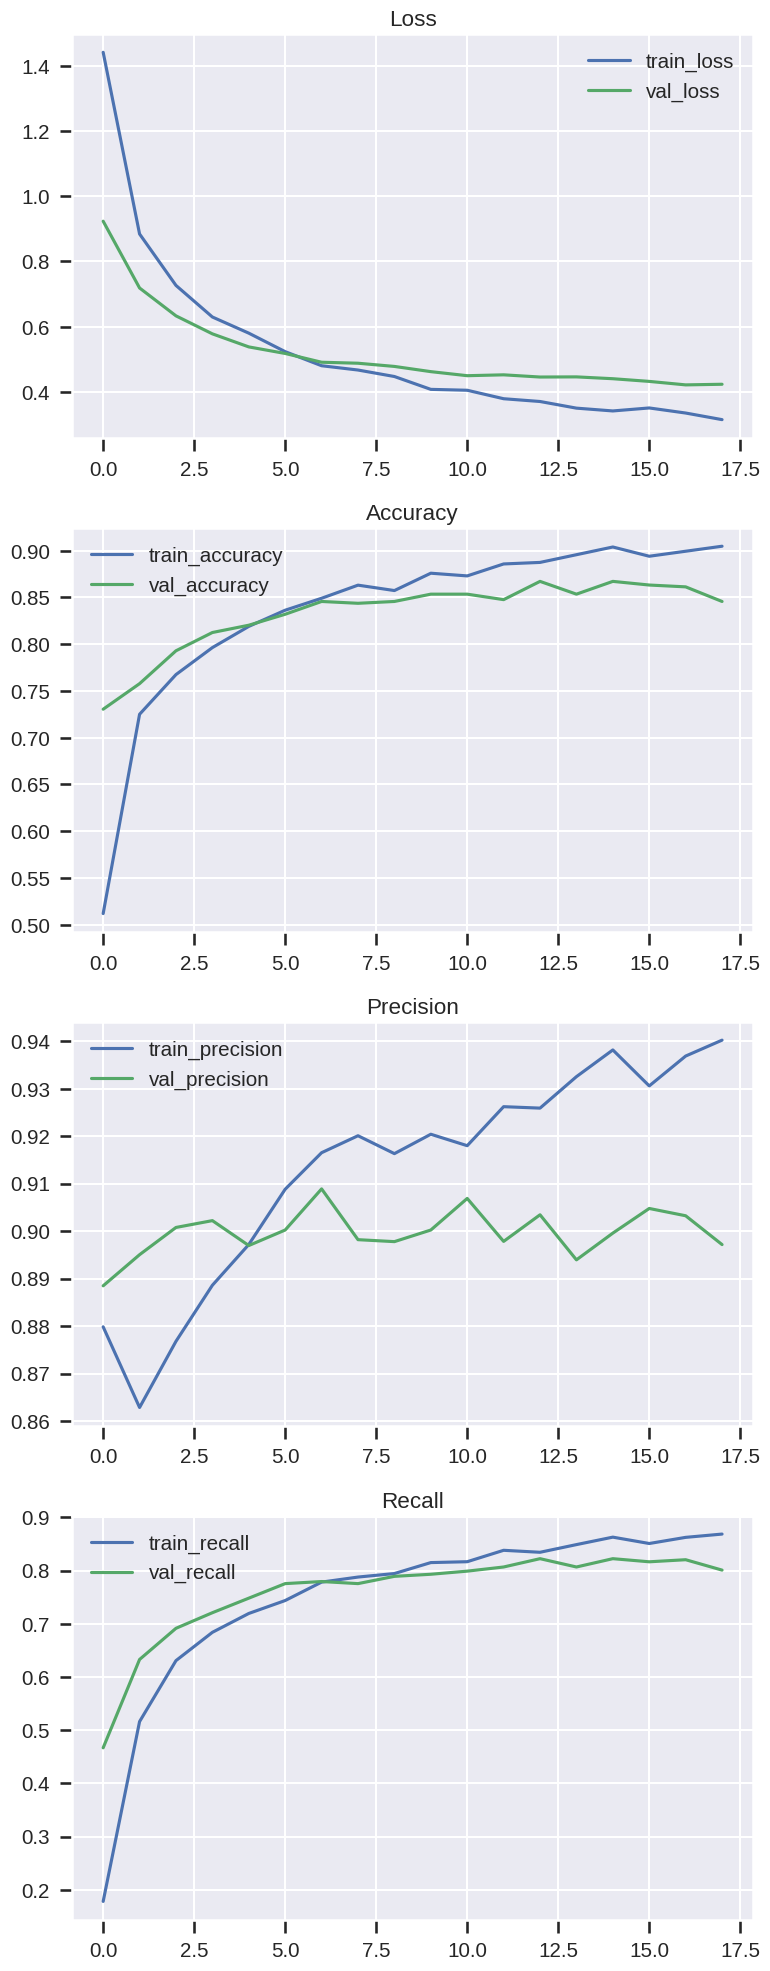

In [9]:
def plot_history(history_obj):
    hist = pd.DataFrame(history_obj.history)
    metrics = ["loss", "accuracy", "precision", "recall"]
    fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 20))
    for idx, metric in enumerate(metrics):
        axes[idx].plot(hist[metric], label=f"train_{metric}")
        axes[idx].plot(hist[f"val_{metric}"], label=f"val_{metric}")
        axes[idx].set_title(metric.capitalize())
        axes[idx].legend()
    plt.tight_layout()

plot_history(history)



## Model Testing & Evaluation

We reload the best `.h5` checkpoint and evaluate on the reserved validation/test splits. Metrics reported:

- categorical accuracy & loss (from Keras evaluation)
- precision, recall, F1 score (micro-averaged)
- per-class precision/recall/F1 via `classification_report`
- confusion matrix heatmap for detailed error analysis


In [ ]:
best_model = keras.models.load_model(MODEL_PATH)
val_metrics = best_model.evaluate(val_ds_ready, verbose=0)
test_metrics = best_model.evaluate(test_ds_ready, verbose=0)

metric_names = best_model.metrics_names
val_results = dict(zip(metric_names, val_metrics))
test_results = dict(zip(metric_names, test_metrics))

print("Validation metrics:")
for k, v in val_results.items():
    print(f" - {k}: {v:.4f}")

print("\nTest metrics:")
for k, v in test_results.items():
    print(f" - {k}: {v:.4f}")


Validation metrics:
 - loss: 0.4249
 - compile_metrics: 0.8652

Test metrics:
 - loss: 0.4739
 - compile_metrics: 0.8273


In [ ]:
def collect_predictions(model, dataset):
    y_true = []
    y_pred = []
    for batch_images, batch_labels in dataset:
        preds = model.predict(batch_images, verbose=0)
        y_true.append(batch_labels.numpy())
        y_pred.append(preds)
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    return y_true, y_pred

y_true, y_pred = collect_predictions(best_model, test_ds_ready)
y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

precision_micro = precision_score(y_true_labels, y_pred_labels, average="micro")
recall_micro = recall_score(y_true_labels, y_pred_labels, average="micro")
f1_micro = f1_score(y_true_labels, y_pred_labels, average="micro")

print(f"Micro Precision: {precision_micro:.4f}")
print(f"Micro Recall: {recall_micro:.4f}")
print(f"Micro F1: {f1_micro:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))



Micro Precision: 0.8273
Micro Recall: 0.8273
Micro F1: 0.8273

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.84      0.89      0.87        47
      Food Organics       0.91      0.84      0.88        63
              Glass       0.85      0.84      0.84        61
              Metal       0.80      0.79      0.80        62
Miscellaneous Trash       0.74      0.72      0.73        58
              Paper       0.82      0.82      0.82        61
            Plastic       0.72      0.72      0.72        58
      Textile Trash       0.85      0.85      0.85        52
         Vegetation       0.90      0.97      0.93        65

           accuracy                           0.83       527
          macro avg       0.83      0.83      0.83       527
       weighted avg       0.83      0.83      0.83       527



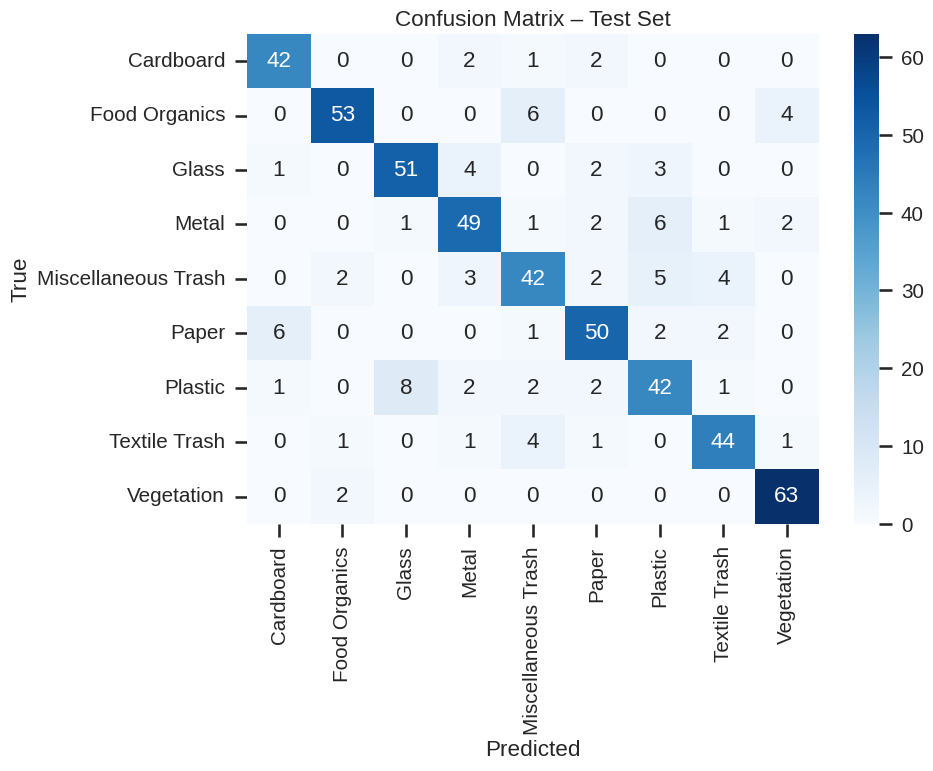

In [ ]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Test Set")
plt.tight_layout()
plt.show()



### Single Image Testing Utility


In [ ]:
# Reloading the saved model
reloaded_model = tf.keras.models.load_model("/content/efficientnetb0_waste_classifier.h5")
preprocess = keras.applications.efficientnet.preprocess_input


In [ ]:
class_names = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash',
    'Paper', 'Plastic', 'Textile Trash', 'Vegetation'
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


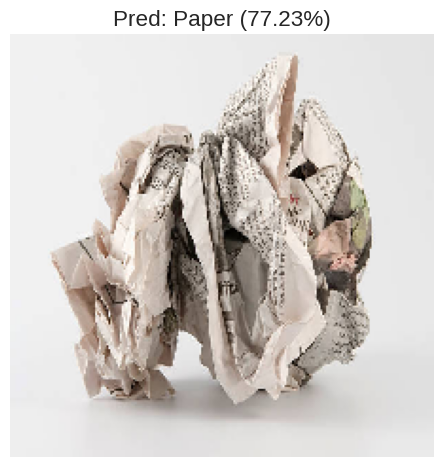

In [ ]:
def predict_single_image(model, image_path: str):
    img = keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess(img_array)
    preds = model.predict(img_array)
    top_idx = np.argmax(preds[0])
    confidence = preds[0][top_idx]
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {class_names[top_idx]} ({confidence:.2%})")
    plt.show()

# Example usage (update path to any image inside the dataset)
predict_single_image(reloaded_model, "/content/paper_trash.jpg")



In [ ]:
#check the version of tensorflow
tf.__version__

'2.19.0'

## Next Steps

- Experiment with different EfficientNet variants (B1/B2) or longer fine-tuning.
- Add automated hyperparameter sweeps (Keras Tuner / Optuna) to optimize dropout/L2.
- Deploy the exported `.h5` via TensorFlow Serving, FastAPI, or TF Lite for mobile robotics bins.

